# Nash Value-Iteration
This tutorial  demonstrates Nash Value-Iteration on a zero-sum strategic (non-extensive) game. 

For the payoff matrix, row player is maximizer, coloumn player is minimizer.

Reference: 
* https://arxiv.org/abs/2006.12007
* http://proceedings.mlr.press/v139/liu21z.html

Status: TODO

## Get Arbitrary MDP Environment

Reward matrices: $[t, s, (a_1, a_2), s'] -> r$

Transition probability matrices: $[t, s, (a_1, a_2), s'] -> p$

In [1]:
import sys
sys.path.append("../..")
from mars.env.mdp import ArbitraryMDP, MDPWrapper
import numpy as np

num_states = 3
num_actions_per_player = 3
num_trans = 3

env = MDPWrapper(ArbitraryMDP(num_states=num_states, num_actions_per_player=num_actions_per_player, num_trans=num_trans))
trans_matrices = env.env.trans_prob_matrices # shape: [dim_transition, dim_state, dim_action (p1*p2), dim_state]
reward_matrices = env.env.trans_prob_matrices # shape: [dim_transition, dim_state, dim_action (p1*p2), dim_state]

oracle_nash_v, oracle_nash_q, _ = env.NEsolver(verbose=False)
oracle_v_star = oracle_nash_v[0]

oracle_v_star = np.mean(oracle_v_star, axis=0)
print(env.observation_space, env.action_space)
# env.render()
obs = env.reset()
print(obs)
done = False
while not np.any(done):
    obs, r, done, _ = env.step([1,0])
    print(obs, r, done)
print('orcale v star: ', oracle_v_star)


Box(0.0, 12.0, (1,), float32) Discrete(3)
[[0], [0]]
[[5], [5]] [0.5610583525729109, -0.5610583525729109] [False, False]
[[6], [6]] [-0.7261994566288021, 0.7261994566288021] [False, False]
[[9], [9]] [-0.8460871060267345, 0.8460871060267345] [True, True]
orcale v star:  -0.29607107415447115


/home/quantumiracle/anaconda3/envs/res/lib/python3.6/site-packages/ecos/ecos.py:26: UserWarning: Converting G to a CSC matrix; may take a while.
  warn("Converting G to a CSC matrix; may take a while.")
/home/quantumiracle/anaconda3/envs/res/lib/python3.6/site-packages/ecos/ecos.py:29: UserWarning: Converting A to a CSC matrix; may take a while.
  warn("Converting A to a CSC matrix; may take a while.")


## Nash Value-Iteration

In [2]:
from mars.env.mdp.utils.nash_solver import NashEquilibriumECOSSolver
from mars.equilibrium_solver import NashEquilibriumMWUSolver
import matplotlib.pyplot as plt
np.set_printoptions(threshold=np.inf)

def get_matrix(q_tab, state):
    return q_tab[state]

def get_nash_value(payoff, solver, solver_itr):
    if solver == 'ecos':
        ne = NashEquilibriumECOSSolver(payoff)
        ne_value = ne[0]@payoff@ne[1].T
    elif solver == 'mwu':
        ne, ne_value = NashEquilibriumMWUSolver(payoff, Itr=solver_itr)
    else:
        raise NotImplementedError

    return ne_value

def get_random_action(dim):
    return np.random.randint(0, dim, size=2)

def get_action_from_nash(q_tab, state, solver, solver_itr):
    """ sample action from current 'nash' strategies. """
    payoff = get_matrix(q_tab, state)
    if solver == 'ecos':
        ne = NashEquilibriumECOSSolver(payoff)
    elif solver == 'mwu':
        ne, ne_value = NashEquilibriumMWUSolver(payoff, Itr=solver_itr)
    else:
        raise NotImplementedError
        
    actions = []
    for dist in ne:
        sample_hist = np.random.multinomial(1, dist)
        a = np.where(sample_hist>0)
        actions.append(a[0][0])
    return actions

def compare_with_oracle(nash_q, oracle_nash_q):
    # nash_q_ = nash_q[:-num_states]  # no nash value for last-step states
    nash_q_ = nash_q
    nash_q_ = nash_q_.reshape(num_trans, num_states, num_actions_per_player, num_actions_per_player)

    mse = np.mean((nash_q_ - np.array(oracle_nash_q))**2)
    return mse

def best_response_value(trans_prob_matrices, reward_matrices, learned_q, num_actions):
    """
    Formulas for calculating best response values:
    1. Nash strategies: (\pi_a^*, \pi_b^*) = \min \max Q(s,a,b), 
        where Q(s,a,b) = r(s,a,b) + \gamma \min \max Q(s',a',b') (this is the definition of Nash Q-value);
    2. Best response (of max player) value: Br V(s) = \min_b \pi(s,a) Q(s,a,b)
    """

    Br_v = []
    Br_q = []
    Nash_strategies = []
    for tm, rm, qm in zip(trans_prob_matrices[::-1], reward_matrices[::-1], learned_q[::-1]): # inverse enumerate 
        if len(Br_v) > 0:
            rm = np.array(rm)+np.array(Br_v[-1])  # broadcast sum on rm's last dim, last one in Nash_v is for the next state
        br_q_values = np.einsum("ijk,ijk->ij", tm, rm)  # transition prob * reward for the last dimension in (state, action, next_state)
        br_q_values = br_q_values.reshape(-1, num_actions, num_actions) # action list to matrix
        Br_q.append(br_q_values)
        br_values = []
        ne_strategies = []
        for q, br_q in zip(qm, br_q_values):
            ne = NashEquilibriumECOSSolver(q)
            ne_strategies.append(ne)
            br_value = np.min(ne[0]@br_q)  # best response againt "Nash" strategy of first player
            br_values.append(br_value)  # each value is a Nash equilibrium value on one state
        Br_v.append(br_values)  # (trans, state)
        Nash_strategies.append(ne_strategies)
    Br_v = Br_v[::-1]  # (#trans, #states)
    Br_q = Br_q[::-1]
    Nash_strategies = Nash_strategies[::-1]

    avg_init_br_v = -np.mean(Br_v[0])  # average best response value of initial states; minus for making it positive
    return avg_init_br_v

In [3]:
def nash_vi(env, gamma = 1, itr = 20000, epsilon = 0.5, update_interval = 200, solver='ecos', solver_itr=None):
    tau = np.sqrt(np.log(num_actions_per_player)/itr)

    # initialize Nash Q table 
    nash_q_tab = np.ones((num_trans*num_states, num_actions_per_player, num_actions_per_player))  # there is (num_trans+1) state space
    print(nash_q_tab.shape)
    print(np.array(oracle_nash_q).shape)

    update_tab = np.zeros((num_trans*num_states, num_actions_per_player, num_actions_per_player)) # a buffer recording updates
    entry_cnts = np.zeros((num_trans*num_states, num_actions_per_player, num_actions_per_player))  # counting the updates in each entry

    mse_list = []
    brv_list = []
    all_itr = 0
    for i in range(itr):
        brv = best_response_value(env.env.trans_prob_matrices, env.env.reward_matrices, \
            nash_q_tab.reshape(num_trans, num_states, num_actions_per_player, num_actions_per_player), num_actions_per_player)
        mse = compare_with_oracle(nash_q_tab, oracle_nash_q)
        if i % 100 == 0:
            print(f"process: {i/itr*100}%, mse: {mse}, brv: {brv}")
        mse_list.append(mse)
        brv_list.append(brv)
        obs = env.reset()
        done = False
        while not np.any(done):
            if np.random.random() > epsilon:
                action = get_action_from_nash(nash_q_tab, obs[0][0], solver, solver_itr)
            else:
                action = get_random_action(num_actions_per_player)
            next_obs, r, done, _ = env.step(action)

            if done[0]:  # there is no action and reward for terminal state, so cannot get nash value for its next state
                nash_target = r[0]
            else:
                next_obs_payoff = get_matrix(nash_q_tab, next_obs[0][0])
                next_obs_nash_value = get_nash_value(next_obs_payoff, solver, solver_itr)
                nash_target = r[0]+gamma*next_obs_nash_value*(1-float(done[0]))  # from agent 0's perspective
            
            all_itr += 1

            # acculmulate updates
            update_tab[obs[0][0], action[0], action[1]] += nash_target
            entry_cnts[obs[0][0], action[0], action[1]] += 1

            # not incremental update, but update with the buffer all at once with the average
            if all_itr % update_interval == 0:
                for j in range(num_trans*num_states):
                    for m in range(num_actions_per_player):
                        for n in range(num_actions_per_player):
                            if entry_cnts[j, m, n]>0:
                                nash_q_tab[j, m, n] = update_tab[j, m, n]/float(entry_cnts[j, m, n])
                # clear buffer after update; found this hurt performance a lot
                # update_tab = np.zeros((num_trans*num_states, num_actions_per_player, num_actions_per_player)) # a buffer recording updates
                # entry_cnts = np.zeros((num_trans*num_states, num_actions_per_player, num_actions_per_player))  # counting the updates in each entry

            # nash_q_tab[obs[0][0], action[0], action[1]] = tau*nash_target + (1-tau)*nash_q_tab[obs[0][0], action[0], action[1]]
            obs = next_obs
    print(nash_q_tab)
    return mse_list, brv_list


(9, 3, 3)
(3, 3, 3, 3)
process: 0.0%, mse: 1.3916078832294372, brv: 0.7608750685387423
process: 0.5%, mse: 0.8543501115156069, brv: 0.801727282519903
process: 1.0%, mse: 0.3607070892950509, brv: 0.6075157811572207
process: 1.5%, mse: 0.23872688658621288, brv: 0.44425786800464095
process: 2.0%, mse: 0.13304331764159644, brv: 0.3873794853629234
process: 2.5%, mse: 0.10494801386867571, brv: 0.38024458898788654
process: 3.0%, mse: 0.07059537844028305, brv: 0.3723852879638792
process: 3.5000000000000004%, mse: 0.06304411810786914, brv: 0.3738429359604288
process: 4.0%, mse: 0.04438746582072972, brv: 0.36182551690277104
process: 4.5%, mse: 0.03999518177909932, brv: 0.37747043927472596
process: 5.0%, mse: 0.03061932475017764, brv: 0.37462949077498336
process: 5.5%, mse: 0.02687366883660428, brv: 0.37450541377918656
process: 6.0%, mse: 0.022402591495479622, brv: 0.3616177370612195
process: 6.5%, mse: 0.020664669682732076, brv: 0.3701112928831995
process: 7.000000000000001%, mse: 0.018215124273

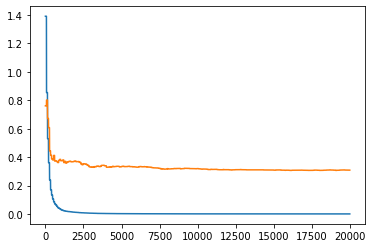

In [10]:
mse_list, brv_list = nash_vi(env, epsilon = 1.0)
plt.plot(mse_list, label='mse')
plt.plot(brv_list, label='brv')


(9, 3, 3)
(3, 3, 3, 3)
process: 0.0%, mse: 1.3916078832294372, brv: 0.7608750685387423
process: 0.5%, mse: 0.8233327835605193, brv: 0.7707971319690743
process: 1.0%, mse: 0.2971282088626439, brv: 0.4224633479307809
process: 1.5%, mse: 0.20506895288018143, brv: 0.5067296001483031
process: 2.0%, mse: 0.1175862806232758, brv: 0.44997890176751865
process: 2.5%, mse: 0.09922780904941239, brv: 0.4248163009558233
process: 3.0%, mse: 0.07329853972068458, brv: 0.4180863053396882
process: 3.5000000000000004%, mse: 0.0629013929854883, brv: 0.4171395537739284
process: 4.0%, mse: 0.04987987953243443, brv: 0.4265797281714949
process: 4.5%, mse: 0.04363683933465685, brv: 0.4116554370721707
process: 5.0%, mse: 0.03764880599084724, brv: 0.40817194607338897
process: 5.5%, mse: 0.03327872140929585, brv: 0.40415683716897016
process: 6.0%, mse: 0.025548998071419735, brv: 0.3826878266660692
process: 6.5%, mse: 0.02280611199778504, brv: 0.39961874188903357
process: 7.000000000000001%, mse: 0.0199284762947736

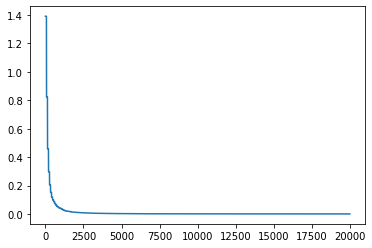

In [23]:
mse_list, _ = nash_vi(env, epsilon = 0.5, solver='mwu', solver_itr=100)
plt.plot(mse_list)

Compare Nash Q-learning using different values of $\epsilon$-greedy.

In [ ]:
mses = []
Itr = 50000
mses.append(nash_vi(env, itr=Itr, epsilon = 0.5)[0])
mses.append(nash_vi(env, itr=Itr, epsilon = 1.)[0]) # epsilon=1, purely random action
mses.append(nash_vi(env, itr=Itr, epsilon = 0.5, solver='mwu', solver_itr=10)[0])
mses.append(nash_vi(env, itr=Itr, epsilon = 1., solver='mwu', solver_itr=10)[0])
mses.append(nash_vi(env, itr=Itr, epsilon = 0.5, solver='mwu', solver_itr=100)[0])
mses.append(nash_vi(env, itr=Itr, epsilon = 1., solver='mwu', solver_itr=100)[0])

save_path = '../../data/compare_nash_vi.npy'
np.save(save_path, np.array(mses))

In [ ]:
labels = ['Ecos-epsilon=0.5', 'Ecos-epsilon=1.0', 'MWU-epsilon=0.5;itr=10', \
    'MWU-epsilon=1.0;itr=10', 'MWU-epsilon=0.5;itr=100', 'MWU-epsilon=1.0;itr=100' ]

plt.figure(figsize=(8, 6), dpi=300)

save_path = '../../data/compare_nash_vi.npy'
mses = np.load(save_path, allow_pickle=True)

for mse, l in zip(mses, labels):
    plt.plot(mse, label=l)

plt.xlabel('Training Episodes')
plt.ylabel('MSE')
plt.title('Comparison of Nash-VI')
plt.yscale('log')
plt.legend()
plt.grid()
plt.savefig('../../data/figs/compare_nash_vi.png')
plt.show()

In [ ]:
# comparison plot across 3 runs

def smooth(y, radius=1000, mode='two_sided'):
    if len(y) < 2*radius+1:
        return np.ones_like(y) * y.mean()
    elif mode == 'two_sided':
        convkernel = np.ones(2 * radius+1)
        return np.convolve(y, convkernel, mode='same') / \
               np.convolve(np.ones_like(y), convkernel, mode='same')
    elif mode == 'causal':
        convkernel = np.ones(radius)
        out = np.convolve(y, convkernel,mode='full') / \
              np.convolve(np.ones_like(y), convkernel, mode='full')
        return out[:-radius+1]


def plot_with_fill(x, data, label, color=None):
    y_m=np.mean(data, axis=0)
    y_std=np.std(data, axis=0)
    y_upper=y_m+y_std
    y_lower=y_m-y_std
    if color is not None:
        plt.fill_between(
        x, list(y_lower), list(y_upper), interpolate=True, facecolor=color, linewidth=0.0, alpha=0.3
    )   
    else:
        plt.fill_between(
        x, list(y_lower), list(y_upper), interpolate=True, linewidth=0.0, alpha=0.3
    )     
    plt.plot(x, list(smooth(y_m)), color=color, label=label)


labels = ['Ecos-epsilon=0.5', 'Ecos-epsilon=1.0', 'MWU-epsilon=0.5;itr=10', \
    'MWU-epsilon=1.0;itr=10', 'MWU-epsilon=0.5;itr=100', 'MWU-epsilon=1.0;itr=100' ]

plt.figure(figsize=(8, 4), dpi=300)

all_data = []
for i in range(1,4):
    save_path = f'../../data/compare_nash_vi{i}.npy'
    mses = np.load(save_path, allow_pickle=True)
    all_data.append(mses)

all_data = np.array(all_data)
print(all_data.shape) 
all_data = np.swapaxes(all_data, 0, 1)
print(all_data.shape) 
x = np.arange(all_data.shape[-1])
for y, l in zip(all_data, labels):
    plot_with_fill(x, y, label=l)

plt.xlabel('Training Episodes')
plt.ylabel('MSE')
plt.title('Comparison of Nash-VI')
plt.yscale('log')
plt.legend()
plt.grid()
plt.savefig('../../data/figs/compare_nash_vi_multiple.png')
plt.show()


In [4]:
tests = 3

for i in range(tests):
    brvs = []
    mses = []
    Itr = 50000

    mse, brv = nash_vi(env, itr=Itr, epsilon = 0.5)
    brvs.append(brv)
    mses.append(mse)
    mse, brv =  nash_vi(env, itr=Itr, epsilon = 0.5)
    brvs.append(brv)
    mses.append(mse)
    mse, brv = nash_vi(env, itr=Itr, epsilon = 1.)
    brvs.append(brv)
    mses.append(mse)
    mse, brv = nash_vi(env, itr=Itr, epsilon = 0.5, solver='mwu', solver_itr=10)
    brvs.append(brv)
    mses.append(mse)
    mse, brv = nash_vi(env, itr=Itr, epsilon = 1., solver='mwu', solver_itr=10)
    brvs.append(brv)
    mses.append(mse)
    mse, brv = nash_vi(env, itr=Itr, epsilon = 0.5, solver='mwu', solver_itr=100)
    brvs.append(brv)
    mses.append(mse)
    mse, brv =nash_vi(env, itr=Itr, epsilon = 1., solver='mwu', solver_itr=100)
    brvs.append(brv)
    mses.append(mse)

    save_path = f'../../data/compare_nash_vi_brv-{i}.npy'
    np.save(save_path, np.array(brvs))
    save_path = f'../../data/compare_nash_vi_mse-{i}.npy'
    np.save(save_path, np.array(mses))

(9, 3, 3)
(3, 3, 3, 3)
process: 0.0%, mse: 1.3916078832294372, brv: 0.7608750685387423


/home/quantumiracle/anaconda3/envs/res/lib/python3.6/site-packages/ecos/ecos.py:26: UserWarning: Converting G to a CSC matrix; may take a while.
  warn("Converting G to a CSC matrix; may take a while.")
/home/quantumiracle/anaconda3/envs/res/lib/python3.6/site-packages/ecos/ecos.py:29: UserWarning: Converting A to a CSC matrix; may take a while.
  warn("Converting A to a CSC matrix; may take a while.")


process: 0.2%, mse: 0.8630624225661778, brv: 0.8251536944399224
process: 0.4%, mse: 0.3936254380062437, brv: 0.7187339419781421
process: 0.6%, mse: 0.2685625302224528, brv: 0.5996664360414597
process: 0.8%, mse: 0.16823020716240478, brv: 0.5570208403672301
process: 1.0%, mse: 0.12598506425353023, brv: 0.4862104158121379
process: 1.2%, mse: 0.09268860705481761, brv: 0.44247393451329464
process: 1.4000000000000001%, mse: 0.07825992754030485, brv: 0.42837640478157274
process: 1.6%, mse: 0.05947458619202275, brv: 0.4086351553310406
process: 1.7999999999999998%, mse: 0.05305172058285292, brv: 0.4094870586002413
process: 2.0%, mse: 0.042363792786496685, brv: 0.43936927470892795
process: 2.1999999999999997%, mse: 0.038308934016392945, brv: 0.4030125490068785
process: 2.4%, mse: 0.032779787705130674, brv: 0.40471113861046804
process: 2.6%, mse: 0.031829182744948475, brv: 0.3730017846897276
process: 2.8000000000000003%, mse: 0.02562660352828937, brv: 0.351952051237884
process: 3.0%, mse: 0.0252

In [ ]:
# comparison plot across 3 runs

def smooth(y, radius=1000, mode='two_sided'):
    if len(y) < 2*radius+1:
        return np.ones_like(y) * y.mean()
    elif mode == 'two_sided':
        convkernel = np.ones(2 * radius+1)
        return np.convolve(y, convkernel, mode='same') / \
               np.convolve(np.ones_like(y), convkernel, mode='same')
    elif mode == 'causal':
        convkernel = np.ones(radius)
        out = np.convolve(y, convkernel,mode='full') / \
              np.convolve(np.ones_like(y), convkernel, mode='full')
        return out[:-radius+1]


def plot_with_fill(x, data, label, color=None):
    y_m=np.mean(data, axis=0)
    y_std=np.std(data, axis=0)
    y_upper=y_m+y_std
    y_lower=y_m-y_std
    if color is not None:
        plt.fill_between(
        x, list(y_lower), list(y_upper), interpolate=True, facecolor=color, linewidth=0.0, alpha=0.3
    )   
    else:
        plt.fill_between(
        x, list(y_lower), list(y_upper), interpolate=True, linewidth=0.0, alpha=0.3
    )     
    plt.plot(x, list(smooth(y_m)), color=color, label=label)


labels = ['Ecos-epsilon=0.5', 'Ecos-epsilon=1.0', 'MWU-epsilon=0.5;itr=10', \
    'MWU-epsilon=1.0;itr=10', 'MWU-epsilon=0.5;itr=100', 'MWU-epsilon=1.0;itr=100' ]

plt.figure(figsize=(6, 3), dpi=300)

all_data = []
for i in range(3):
    save_path = f'../../data/compare_nash_vi_brv-{i}.npy'
    mses = np.load(save_path, allow_pickle=True)
    all_data.append(mses)

all_data = np.array(all_data)
print(all_data.shape) 
all_data = np.swapaxes(all_data, 0, 1)
print(all_data.shape) 
all_data = np.concatenate((all_data[:1], all_data[2:]))  # mada a mistake above with extra data
print(all_data.shape) 

x = np.arange(all_data.shape[-1])
for y, l in zip(all_data, labels):
    plot_with_fill(x, y, label=l)

plt.axhline(y=0.296, color='black', linestyle='--')
plt.xlabel('Training Episodes')
plt.ylabel('Exploitability')
plt.title('Nash-VI with Different Settings')
plt.yscale('log')
plt.legend()
plt.grid()
plt.savefig('../../data/figs/compare_nash_vi_multiple_brv.png', bbox_inches='tight')
plt.show()


In [ ]:
# comparison plot across 3 runs

def smooth(y, radius=1000, mode='two_sided'):
    if len(y) < 2*radius+1:
        return np.ones_like(y) * y.mean()
    elif mode == 'two_sided':
        convkernel = np.ones(2 * radius+1)
        return np.convolve(y, convkernel, mode='same') / \
               np.convolve(np.ones_like(y), convkernel, mode='same')
    elif mode == 'causal':
        convkernel = np.ones(radius)
        out = np.convolve(y, convkernel,mode='full') / \
              np.convolve(np.ones_like(y), convkernel, mode='full')
        return out[:-radius+1]


def plot_with_fill(x, data, label, color=None):
    y_m=np.mean(data, axis=0)
    y_std=np.std(data, axis=0)
    y_upper=y_m+y_std
    y_lower=y_m-y_std
    if color is not None:
        plt.fill_between(
        x, list(y_lower), list(y_upper), interpolate=True, facecolor=color, linewidth=0.0, alpha=0.3
    )   
    else:
        plt.fill_between(
        x, list(y_lower), list(y_upper), interpolate=True, linewidth=0.0, alpha=0.3
    )     
    plt.plot(x, list(smooth(y_m)), color=color, label=label)


labels = ['Ecos-epsilon=0.5', 'Ecos-epsilon=1.0', 'MWU-epsilon=0.5;itr=10', \
    'MWU-epsilon=1.0;itr=10', 'MWU-epsilon=0.5;itr=100', 'MWU-epsilon=1.0;itr=100' ]

plt.figure(figsize=(6, 3), dpi=300)

all_data = []
for i in range(3):
    save_path = f'../../data/compare_nash_vi_mse-{i}.npy'
    mses = np.load(save_path, allow_pickle=True)
    all_data.append(mses)

all_data = np.array(all_data)
print(all_data.shape) 
all_data = np.swapaxes(all_data, 0, 1)
print(all_data.shape) 
all_data = np.concatenate((all_data[:1], all_data[2:]))
print(all_data.shape) 

x = np.arange(all_data.shape[-1])
for y, l in zip(all_data, labels):
    plot_with_fill(x, y, label=l)

plt.xlabel('Training Episodes')
plt.ylabel('MSE')
plt.title('Nash-VI with Different Settings')
plt.yscale('log')
plt.legend()
plt.grid()
plt.savefig('../../data/figs/compare_nash_vi_multiple_mse.png', bbox_inches='tight')
plt.show()
